In [1]:
!pip install vaderSentiment
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
from textblob import Word
from textblob import TextBlob
from pathlib import Path
from google.colab import files
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read in file
file_path = '/content/drive/MyDrive/proj4-repo/data/cleaned_data/cleaned_training_tweets.csv'

df = pd.read_csv(file_path)

df.head()

,target,cleaned_text
0,0,upset update facebook texting might cry result...
1,0,dived many time managed save rest go bound
2,0,whole body feel itchy like fire
3,0,behaving see
4,0,whole crew


## grab top  20 rows

In [21]:
top_20 = df['cleaned_text'].head(20).tolist()
print(top_20)

['upset update facebook texting might cry result school today', 'dived many time managed save rest go bound', 'whole body feel itchy like fire', 'behaving see', 'whole crew', 'need hug', 'hey long time rain bit bit lol fine thanks', 'nope', 'que muera', 'spring break plain snowing', 'ear', 'bear watch thought ua loss embarrassing', 'idk never talk anymore', 'really zac', 'wish got watch miss', 'death scene hurt severely watch film wry director cut', 'file tax', 'ahh ive always wanted see rent love', 'oh drinking forgotten table', 'day get much done']


In [18]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [5]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [6]:
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]


In [28]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

#create an empty list
sentiment_labels = []
sentiment_scores = []

for text in top_20:
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    #Grab rankings
    ranking = np.argsort(scores)
    #ranking = ranking[::-1]
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{text}) {l} {np.round(float(s), 4)}")
    sentiment_labels.append(l)
    sentiment_scores.append(s)


upset update facebook texting might cry result school today) negative 0.7991
dived many time managed save rest go bound) neutral 0.7144
whole body feel itchy like fire) negative 0.5691
behaving see) neutral 0.7538
whole crew) neutral 0.7274
need hug) neutral 0.6576
hey long time rain bit bit lol fine thanks) positive 0.7924
nope) neutral 0.4958
que muera) neutral 0.599
spring break plain snowing) neutral 0.8016
ear) neutral 0.5187
bear watch thought ua loss embarrassing) negative 0.9043
idk never talk anymore) negative 0.7181
really zac) neutral 0.7759
wish got watch miss) neutral 0.753
death scene hurt severely watch film wry director cut) negative 0.9322
file tax) neutral 0.6537
ahh ive always wanted see rent love) positive 0.6469
oh drinking forgotten table) neutral 0.5659
day get much done) neutral 0.6301


In [34]:
bert_df = pd.DataFrame({'cleaned_text':top_20, 'sentiment_scores':sentiment_scores, 'sentiment_labels':sentiment_labels})

In [35]:
bert_df.head()

,cleaned_text,sentiment_scores,sentiment_labels
0,upset update facebook texting might cry result...,0.799102,negative
1,dived many time managed save rest go bound,0.714438,neutral
2,whole body feel itchy like fire,0.569125,negative
3,behaving see,0.753781,neutral
4,whole crew,0.727418,neutral


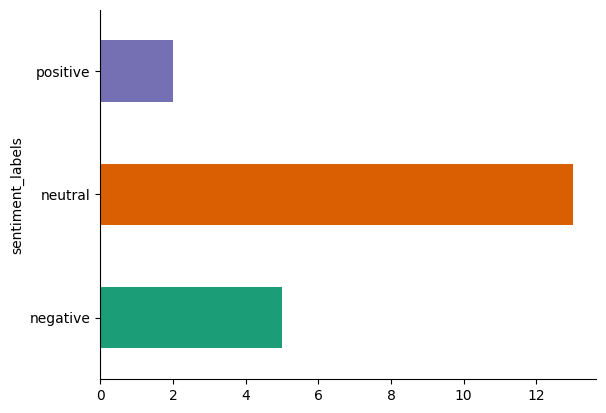

In [43]:
# @title sentiment_labels

from matplotlib import pyplot as plt
import seaborn as sns
bert_df.groupby('sentiment_labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

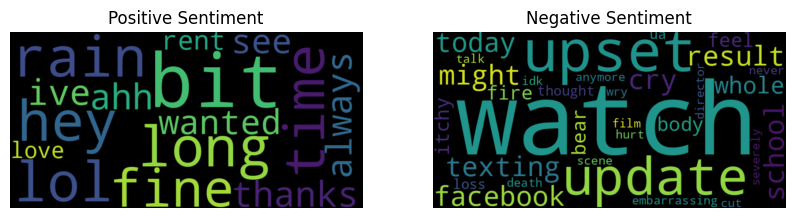

In [41]:
# @title Word Cloud by Sentiment

import matplotlib.pyplot as plt
from wordcloud import WordCloud
positive_words = ' '.join(bert_df[bert_df['sentiment_labels'] == 'positive']['cleaned_text'].tolist())
negative_words = ' '.join(bert_df[bert_df['sentiment_labels'] == 'negative']['cleaned_text'].tolist())
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=400).generate(positive_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment')
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400).generate(negative_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
_ = plt.title('Negative Sentiment')

In [42]:
bert_df.to_csv('bert_sentiment_analysis.csv', index=False)
